In [3]:
from ultralytics import YOLOv10
# Load a pretrained YOLOv10n model
model = YOLOv10("/home/disk3/jsa/projects/yolov10/runs/detect/train11/weights/best.pt")
 
# Perform object detection on an image
# results = model("test1.jpg")
results = model.predict("/home/disk3/jsa/projects/yolov10/data_build/data/all_rebar/98.PNG")
 
# Display the results
print(results[0])



image 1/1 /home/disk3/jsa/projects/yolov10/data_build/data/all_rebar/98.PNG: 448x640 9 rebars, 31.7ms
Speed: 1.7ms preprocess, 31.7ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)
ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'rebar'}
obb: None
orig_img: array([[[133, 133, 133],
        [119, 119, 119],
        [125, 125, 125],
        ...,
        [113, 113, 113],
        [113, 113, 113],
        [113, 113, 113]],

       [[121, 121, 121],
        [132, 132, 132],
        [128, 128, 128],
        ...,
        [117, 117, 117],
        [117, 117, 117],
        [117, 117, 117]],

       [[131, 131, 131],
        [130, 130, 130],
        [119, 119, 119],
        ...,
        [117, 117, 117],
        [117, 117, 117],
        [117, 117, 117]],

       ...,

       [[121, 121, 121],
        [125, 125, 125],
        [122, 122, 122],
        ...,
        [143, 143, 143],
    

YOLOv10n summary (fused): 285 layers, 2694806 parameters, 0 gradients, 8.2 GFLOPs


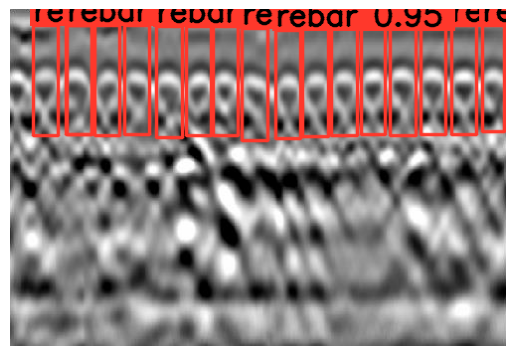

count: 17
save done


In [5]:
import cv2
import torch
import numpy as np
from ultralytics.data.augment import LetterBox
from ultralytics.nn.autobackend import AutoBackend
import matplotlib.pyplot as plt

def preprocess_letterbox(image):
    letterbox = LetterBox(new_shape=640, stride=32, auto=True)
    image = letterbox(image=image)
    image = (image[..., ::-1] / 255.0).astype(np.float32) # BGR to RGB, 0 - 255 to 0.0 - 1.0
    image = image.transpose(2, 0, 1)[None]  # BHWC to BCHW (n, 3, h, w)
    image = torch.from_numpy(image)
    return image

def preprocess_warpAffine(image, dst_width=640, dst_height=640):
    scale = min((dst_width / image.shape[1], dst_height / image.shape[0]))
    ox = (dst_width  - scale * image.shape[1]) / 2
    oy = (dst_height - scale * image.shape[0]) / 2
    M = np.array([
        [scale, 0, ox],
        [0, scale, oy]
    ], dtype=np.float32)
    
    img_pre = cv2.warpAffine(image, M, (dst_width, dst_height), flags=cv2.INTER_LINEAR,
                             borderMode=cv2.BORDER_CONSTANT, borderValue=(114, 114, 114))
    IM = cv2.invertAffineTransform(M)

    img_pre = (img_pre[...,::-1] / 255.0).astype(np.float32)
    img_pre = img_pre.transpose(2, 0, 1)[None]
    img_pre = torch.from_numpy(img_pre)
    return img_pre, IM

def postprocess(pred, IM=[], conf_thres=0.25):

    # 输入是模型推理的结果，即8400个预测框
    # 1,8400,84 [cx,cy,w,h,class*80]
    boxes = []
    for item in pred[0]:
        cx, cy, w, h = item[:4]
        label = item[4:].argmax()
        confidence = item[4 + label]
        if confidence < conf_thres:
            continue
        left    = cx - w * 0.5
        top     = cy - h * 0.5
        right   = cx + w * 0.5
        bottom  = cy + h * 0.5
        boxes.append([left, top, right, bottom, confidence, label])

    boxes = np.array(boxes)
    lr = boxes[:,[0, 2]]
    tb = boxes[:,[1, 3]]
    boxes[:,[0,2]] = IM[0][0] * lr + IM[0][2]
    boxes[:,[1,3]] = IM[1][1] * tb + IM[1][2]
    
    return boxes

def hsv2bgr(h, s, v):
    h_i = int(h * 6)
    f = h * 6 - h_i
    p = v * (1 - s)
    q = v * (1 - f * s)
    t = v * (1 - (1 - f) * s)
    
    r, g, b = 0, 0, 0

    if h_i == 0:
        r, g, b = v, t, p
    elif h_i == 1:
        r, g, b = q, v, p
    elif h_i == 2:
        r, g, b = p, v, t
    elif h_i == 3:
        r, g, b = p, q, v
    elif h_i == 4:
        r, g, b = t, p, v
    elif h_i == 5:
        r, g, b = v, p, q

    return int(b * 255), int(g * 255), int(r * 255)

def random_color(id):
    h_plane = (((id << 2) ^ 0x937151) % 100) / 100.0
    s_plane = (((id << 3) ^ 0x315793) % 100) / 100.0
    return hsv2bgr(h_plane, s_plane, 1)

if __name__ == "__main__":
    
    img = cv2.imread("/home/disk3/jsa/projects/yolov10/data_build/data/all_rebar/97.PNG")

    # img_pre = preprocess_letterbox(img)
    img_pre, IM = preprocess_warpAffine(img)

    model  = AutoBackend(weights="/home/disk3/jsa/projects/yolov10/runs/detect/train4/weights/last.pt")
    # model  = AutoBackend(weights="/home/disk3/jsa/projects/yolov10/runs/detect/train10/weights/last.pt")
    # model  = AutoBackend(weights="/home/disk3/jsa/projects/yolov10/runs/detect/train17/weights/last.pt")
    names  = model.names
    result = model(img_pre)['one2one'][0].transpose(-1, -2) # 1,8400,84
    boxes  = postprocess(result, IM)

    count = 0
    for obj in boxes:
        count += 1
        left, top, right, bottom = int(obj[0]), int(obj[1]), int(obj[2]), int(obj[3])
        confidence = obj[4]
        label = int(obj[5])
        color = random_color(label)
        cv2.rectangle(img, (left, top), (right, bottom), color=color ,thickness=2, lineType=cv2.LINE_AA)
        caption = f"{names[label]} {confidence:.2f}"
        w, h = cv2.getTextSize(caption, 0, 1, 2)[0]
        cv2.rectangle(img, (left - 3, top - 33), (left + w + 10, top), color, -1)
        cv2.putText(img, caption, (left, top - 5), 0, 1, (0, 0, 0), 2, 16)

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.axis('off')  # 隐藏坐标轴
    plt.show()
    print(f"count: {count}")
    print("save done")  
